In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from object_loc_helper import GeneratorMultipleOutputs, get_simple_model, iou, PlotLosses

Using TensorFlow backend.


Intersection Over Union Paper
https://arxiv.org/pdf/1608.01471.pdf

In [14]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches
from object_loc_helper import get_class_names_map, PlotLosses

In [3]:
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'

# Construyo generador custom

In [4]:
train_folder = 'reduced_dataset/images/train'
val_folder = 'reduced_dataset/images/val'

In [5]:
annotations_dict_train = np.load('reduced_dataset/annotations_train_5_classes.npy').flat[0]
annotations_dict_val = np.load('reduced_dataset/annotations_val_5_classes.npy').flat[0]

In [6]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_train, train_folder, 64, flip = 'random')
val_generator_multiple_outputs = GeneratorMultipleOutputs(annotations_dict_val, val_folder, 159, flip = 'random')

Found 1564 images belonging to 5 classes.
Found 159 images belonging to 5 classes.


In [7]:
model = get_simple_model(input_shape=(375, 500, 3), n_classes=5)

In [8]:
losses = {"category_output": "categorical_crossentropy", 
          "bounding_box": "mean_squared_error"
         }
metrics = {"category_output": "accuracy", 
           "bounding_box": [iou, "mae"]
          }
lossWeights = {"category_output": 1.0, 
               "bounding_box":  120.0,
              }

In [9]:
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, rmsprop
filename = '5_test'
checkpoint = ModelCheckpoint(filepath = filename+'_best.hdf5', 
                             monitor='val_category_output_acc', save_best_only=True)
model.compile(loss=losses,
              #optimizer=rmsprop(),
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

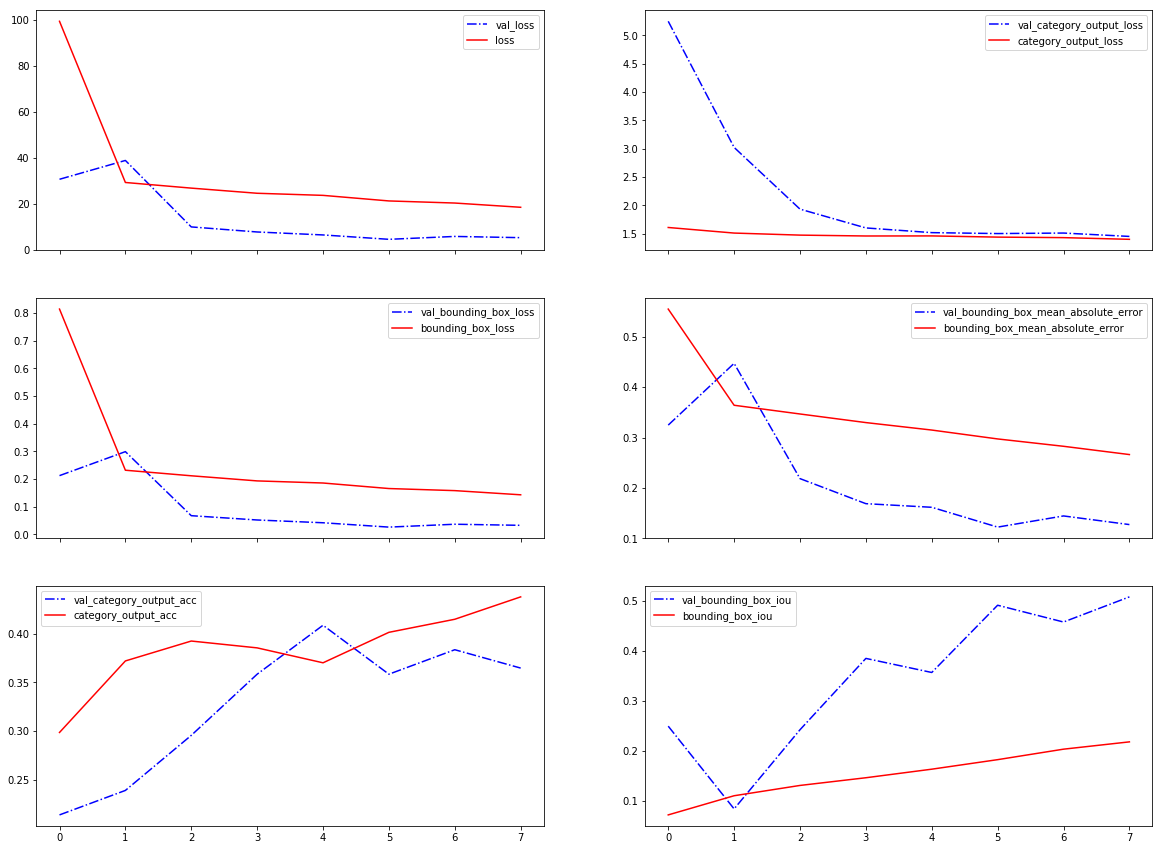

Epoch 9/2000
24/25 [===========================>..] - ETA: 0s - loss: 17.4454 - category_output_loss: 1.3765 - bounding_box_loss: 0.1339 - category_output_acc: 0.4355 - bounding_box_iou: 0.2315 - bounding_box_mean_absolute_error: 0.2600

KeyboardInterrupt: 

In [10]:
plot_losses = PlotLosses(1)
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=2000,
        validation_data=val_generator_multiple_outputs, callbacks = [plot_losses, checkpoint]
        )

In [11]:
model.evaluate_generator(val_generator_multiple_outputs)

[6.0993499755859375,
 1.4450992345809937,
 0.038785420358181,
 0.49056604504585266,
 0.4171670973300934,
 0.1551366150379181]

In [12]:
model.evaluate_generator(train_generator_multiple_outputs)

[6.54080606299593,
 1.3182526528073089,
 0.043521278149560284,
 0.5063938615877001,
 0.378710380752983,
 0.1702160732749173]

In [13]:
model.save_weights(filename+'_last.hdf5')